### Import Libraries

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import requests
import json
import praw
import time
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier

%matplotlib inline

/Users/mikethisyamondol/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Data Collection
Let's start off collecting our data. The URL below (shout out to Felippe Rodrigues) goes through step by step how to use the Python Reddit API Wrapper (PRAW) for data collection.

http://www.storybench.org/how-to-scrape-reddit-with-python/ 

PRAW Documentation: https://praw.readthedocs.io/en/latest/getting_started/authentication.html#script-application

In [2]:
#Removed username and password for privacy, but those are required fields.
reddit = praw.Reddit(client_id='Bqkkt_apVXguaQ',
                     client_secret='nCy7NK-SBX4V2ujHlQ7j_KHXZYU',
                     user_agent='MT_1',
                     username='miket5099',
                     password='nycdsicc5')

In [3]:
#Set lpt variable to the LifeProTips subreddit data
#Pulling in the top 1000 posts (if available)
lpt = reddit.subreddit('LifeProTips')
lpt = lpt.top(limit = 1000)

In [4]:
#Create an dictionary with empty lists to populate data from lpt.top
lpt_dict = { "id": [],"text": [], "target": []}

#For loop to append data into empty lists within lpt_dict. Assigning positive outcome as LPT.
for post in lpt:
        lpt_dict["id"].append(post.id)
        lpt_dict["text"].append(post.title + " " + post.selftext) # + post.selftext
        #lpt_dict["comments"].append(post.comments)
        lpt_dict["target"].append(1)

In [5]:
#Create Pandas DataFrame from disctionary for easy manipulation
lpt_df = pd.DataFrame(lpt_dict, columns = ["id", "text", "target"])
lpt_df.head()

,id,text,target
0,6s7ln1,"LPT: if your LPT is about fucking coconuts, it...",1
1,89unew,"LPT: If you like one song by an artist, but do...",1
2,7fnpgs,LPT: Pay Attention to the smell of your home w...,1
3,98d589,LPT: for those of you going to college for the...,1
4,7yvxw4,LPT: X percent of Y is equal to Y percent of X...,1


In [6]:
lpt_df[1:].head()

,id,text,target
1,89unew,"LPT: If you like one song by an artist, but do...",1
2,7fnpgs,LPT: Pay Attention to the smell of your home w...,1
3,98d589,LPT: for those of you going to college for the...,1
4,7yvxw4,LPT: X percent of Y is equal to Y percent of X...,1
5,6a5j3z,LPT : If you are asked to create an account in...,1


In [7]:
#Set lpt variable to the UnethicalLifeProTips subreddit data
#Pulling in the top 1000 posts (if available)
ulpt = reddit.subreddit('UnethicalLifeProTips')
ulpt = ulpt.top(limit = 1000)

In [8]:
#Create an dictionary with empty lists to populate data from ulpt.top
ulpt_dict = { "id": [],"text": [], "target": []}

#For loop to append data into empty lists within lpt_dict. Assigning positive outcome as LPT.
for post in ulpt:
        ulpt_dict["id"].append(post.id)
        ulpt_dict["text"].append(post.title + " " + post.selftext) # + post.selftext
        #lpt_dict["comments"].append(post.comments)
        ulpt_dict["target"].append(0)

In [9]:
#Create Pandas DataFrame from disctionary for easy manipulation
ulpt_df = pd.DataFrame(ulpt_dict, columns = ["id", "text", "target"])
ulpt_df.head()

,id,text,target
0,99vv9n,ULPT: If you glue a dead wasp to the palm of y...,0
1,9aoxrm,ULPT: Concerned about unvaccinated children sp...,0
2,9a1s90,ULPT: for new students staying in dorms. If yo...,0
3,99n2pw,ULPT: Tell your friends that you've made them ...,0
4,9b9t5n,ULPT: Need friends? Create an attractive fake ...,0


In [10]:
#Combine the two DataFrames together. 
df = pd.concat([lpt_df, ulpt_df])

In [11]:
df.head()

,id,text,target
0,6s7ln1,"LPT: if your LPT is about fucking coconuts, it...",1
1,89unew,"LPT: If you like one song by an artist, but do...",1
2,7fnpgs,LPT: Pay Attention to the smell of your home w...,1
3,98d589,LPT: for those of you going to college for the...,1
4,7yvxw4,LPT: X percent of Y is equal to Y percent of X...,1


In [12]:
df.to_csv("./data/subreddits_1")

In [13]:
#Please note, I pulled in the post ID's to do a final check to make sure no duplicate posts were pulled in.
df["id"].value_counts().sort_values(ascending = False).head()

9eg1b1    1
6toivu    1
7k0e05    1
8cbkcb    1
8y6xx7    1
Name: id, dtype: int64

In [14]:
#Check if our classes are balanced. In this case, they are.
df["target"].value_counts()

0    912
1    881
Name: target, dtype: int64

I pulled in the ShittyLifeProTips subreddit as a holdout group to see if the models can tell if these are good or bad tips. This is obviously not required, but I wanted to do this for fun and see what happens.

In [15]:
slpt = reddit.subreddit('ShittyLifeProTips')
slpt = slpt.top(limit = 1000)

In [16]:
#Create an dictionary with empty lists to populate data from slpt.top
slpt_dict = {"text": []}

#For loop to append data into empty lists within ulpt_dict. Assigning negative outcome as ULPT.
for post in slpt:
        slpt_dict["text"].append(post.title + " " + post.selftext)

In [17]:
slpt_df = pd.DataFrame(slpt_dict, columns = ["text"])
#Set target to 0 as the ShittyLifeProTips are likely to be similar to the UnethicalLifeProTips.
slpt_df["target"] = 0
slpt_df.head()

,text,target
0,LPT: Don't have YouTube Red? Access it for fre...,0
1,"If you stain a shirt, you can simply outline t...",0
2,Public bathroom LPT,0
3,LPT: Glue a tiny mirror over the picture of yo...,0
4,Cutting your tennis balls in half allows you t...,0


Another way to gather data is by using requests.get (which is a more generalized way if you're not gathering data from Reddit). Since by default, Reddit will only you the top 25 posts, we need to write a for loop to gather more posts using `xyz["data"]["after"]` to identify the last post that was pulled, and pass into `https://www.reddit.com/r/LifeProTips.json?after=` for subsequent requests. Since we want to be respectful (and don't want Reddit to think we're up to any funny business), we use `time.sleep(3)` to pause 3 seconds in between pings to their server.

Since this method was not used, I have commented this out.

In [18]:
# plt_list = []
# url = "https://www.reddit.com/r/LifeProTips.json"
# for i in range (1,50):
#     temp_json = requests.get(url, headers={'User-agent': 'MT'}).json()
#     temp_list = []
#     for j in range (1,25):
#         temp_list.append(temp_json["data"]["children"][j]["data"]["title"])
#     plt_list.extend(temp_list)
#     url = "https://www.reddit.com/r/LifeProTips.json?after=" + temp_json["data"]["after"]
#     time.sleep(3)

In [19]:
# uplt_list = []
# url = "https://www.reddit.com/r/UnethicalLifeProTips.json"
# for i in range (1,50):
#     temp_json = requests.get(url, headers={'User-agent': 'MT'}).json()
#     temp_list = []
#     for j in range (1,25):
#         temp_list.append(temp_json["data"]["children"][j]["data"]["title"])
#     uplt_list.extend(temp_list)
#     url = "https://www.reddit.com/r/UnethicalLifeProTips.json?after=" + temp_json["data"]["after"]
#     time.sleep(3)

### Cleaning/Pre-processing
Now that we have a pretty solid data set, let's see what we can do to clean this up. Here's what we can start with:

- Change everything to lowercase since we don't want our model to see "Hello" and "hello" as different words.
- Remove puncutation as they will most likely not be helpful in subreddit classification.
- Remove obvious words that will help classify the posts, i.e. "LPT" and "ULPT".
- Remove common words e.g. "the", "and", etc. by removing stop words. (We may need to customize this list).
    
Some points above will be done when we vectorize our title series such as removing stop words.

In [20]:
#Switch everything in title column to lowercase
df["text"] = df["text"].map(lambda x: x.lower())
#remove puncuation
df["text"] = df["text"].str.replace("[^\w\s]",'')
#Clean out obvious words that help classify posts i.e. ulpt and lpt
df["text"] = df["text"].map(lambda x: x.replace("ulpt ", ""))
df["text"] = df["text"].map(lambda x: x.replace("lpt ", ""))

In [21]:
#Lets clean our holdout set as well.
slpt_df["text"] = slpt_df["text"].map(lambda x: x.lower())
slpt_df["text"] = slpt_df["text"].str.replace("[^\w\s]",'')
slpt_df["text"] = slpt_df["text"].map(lambda x: x.replace("ulpt ", ""))
slpt_df["text"] = slpt_df["text"].map(lambda x: x.replace("slpt ", ""))
slpt_df["text"] = slpt_df["text"].map(lambda x: x.replace("lpt ", ""))

In [22]:
df[1:].head()

,id,text,target
1,89unew,if you like one song by an artist but dont dig...,1
2,7fnpgs,pay attention to the smell of your home when y...,1
3,98d589,for those of you going to college for the firs...,1
4,7yvxw4,x percent of y is equal to y percent of x so i...,1
5,6a5j3z,if you are asked to create an account in orde...,1


In [23]:
slpt_df.head()

,text,target
0,dont have youtube red access it for free by us...,0
1,if you stain a shirt you can simply outline th...,0
2,public bathroom,0
3,glue a tiny mirror over the picture of you on ...,0
4,cutting your tennis balls in half allows you t...,0


In [24]:
df.to_csv("./data/subreddits_1")

In [25]:
slpt_df.to_csv("./data/slpt")

### Modeling

Let's start modeling. We can set up pipelines to vectorize and fit our models, then feed that into GridSearchCV to optimize our hyper-parameters.

In [26]:
#Check our baseline Accuracy score. If we were to predict all posts as UnethicalLifeProTips, our accuracy would be 51%.
#The hope is that our models will beat this score.
df["target"].value_counts(normalize = True)

0    0.508645
1    0.491355
Name: target, dtype: float64

In [27]:
#We want to set our X as the text column and our y as the target column of the dataframe.
X = df["text"]
y = df["target"]

In [28]:
#Can't forget to do a train/test split. It's always a good idea to stratify to ensure your y classes hold the same ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 25, test_size = 0.3)

In [29]:
#Lets first instantiate our Vectorizers and Models we want to use and feed into our pipeline.
cvect = CountVectorizer(stop_words="english")
tvect = TfidfVectorizer(stop_words="english")
multinb = MultinomialNB()
logreg = LogisticRegression()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
ada = AdaBoostClassifier()

#### Model 1 - CountVectorizer + MultinomialNB

In [30]:
pipe_1 = Pipeline([
    ("cvect", cvect),
    ("multinb", multinb)
])

params = {
    "cvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4)],
    "cvect__max_df" : [1.0, 0.9, 0.8],
    "multinb__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0, 100.0]
    
}

gs_1 = GridSearchCV(pipe_1, param_grid=params)
gs_1.fit(X_train, y_train)

print(gs_1.best_params_)
print("Train Score", gs_1.best_score_)
print("Test Score", gs_1.score(X_test, y_test))

{'cvect__max_df': 1.0, 'cvect__ngram_range': (1, 1), 'multinb__alpha': 1.0}
Train Score 0.7370517928286853
Test Score 0.7453531598513011


In [31]:
gs_1.predict_proba(X_test)[:5]

array([[9.33266902e-01, 6.67330976e-02],
       [9.99747742e-01, 2.52258144e-04],
       [4.08613320e-04, 9.99591387e-01],
       [2.78520676e-09, 9.99999997e-01],
       [9.99965066e-01, 3.49343109e-05]])

In [32]:
predictions_1 = gs_1.predict(X_test)

In [33]:
test_pred_1 = pd.DataFrame()
test_pred_1["post"] = X_test
test_pred_1["target"] = y_test
test_pred_1["predictions"] = predictions_1

In [34]:
test_pred_1.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [35]:
#Confusion Matrix
cm1 = confusion_matrix(test_pred_1["target"], test_pred_1["predictions"])

cm1_df = pd.DataFrame(cm1, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm1_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,180,94
Actual ProTip,43,221


Holdout data against CountVectorizer + MultinomialNB.

In [36]:
hold_preds_1 = gs_1.predict(slpt_df["text"])

holdout_pred_1 = pd.DataFrame()
holdout_pred_1["post"] = slpt_df["text"]
holdout_pred_1["predictions"] = hold_preds_1

In [37]:
#We know all the posts in this holdout set should be closely associated with UnethicalLifeProTips
holdout_pred_1["predictions"].value_counts()

0    521
1    472
Name: predictions, dtype: int64

#### Model 2 - TF-IDF Vectorizer + MultinomialNB

In [38]:
pipe_2 = Pipeline([
    ("tvect", tvect),
    ("multinb", multinb)
])

params = {
    "tvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4), (1,5)],
    "tvect__max_df" : [1.0, 0.9, 0.8],
    "multinb__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0, 100.0]
    
}

gs_2 = GridSearchCV(pipe_2, param_grid=params)
gs_2.fit(X_train, y_train)

print(gs_2.best_params_)
print("Train Score", gs_2.best_score_)
print("Test Score", gs_2.score(X_test, y_test))

{'multinb__alpha': 10.0, 'tvect__max_df': 1.0, 'tvect__ngram_range': (1, 3)}
Train Score 0.7617529880478088
Test Score 0.7639405204460966


In [39]:
gs_2.predict_proba(X_test)[:5]

array([[0.50132354, 0.49867646],
       [0.53159162, 0.46840838],
       [0.47008246, 0.52991754],
       [0.47377265, 0.52622735],
       [0.55482059, 0.44517941]])

In [40]:
predictions_2 = gs_2.predict(X_test)

test_pred_2 = pd.DataFrame()
test_pred_2["post"] = X_test
test_pred_2["target"] = y_test
test_pred_2["predictions"] = predictions_2
test_pred_2.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [41]:
#Confusion Matrix
cm2 = confusion_matrix(test_pred_2["target"], test_pred_2["predictions"])

cm2_df = pd.DataFrame(cm2, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm2_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,196,78
Actual ProTip,49,215


Holdout data against TF-IDF Vectorizer + MultinomialNB.

In [42]:
hold_preds_2 = gs_2.predict(slpt_df["text"])

holdout_2 = pd.DataFrame()
holdout_2["post"] = slpt_df["text"]
holdout_2["predictions"] = hold_preds_2

In [43]:
#We know all the posts in this holdout set should be associated with UnethicalLifeProTips
holdout_2["predictions"].value_counts()

0    637
1    356
Name: predictions, dtype: int64

#### Model 3 - CountVectorizer + Logistic Regression

In [44]:
pipe_3 = Pipeline([
    ("cvect", cvect),
    ("logreg", logreg)
])

params = {
    "cvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4)],
    "cvect__max_df" : [1.0, 0.9, 0.8],
    "logreg__penalty" : ["l1", "l2"],
    "logreg__C" : [0.1, 0.5, 1, 5, 10]
    
}

gs_3 = GridSearchCV(pipe_3, param_grid=params)
gs_3.fit(X_train, y_train)

print(gs_3.best_params_)
print("Train Score", gs_3.best_score_)
print("Test Score", gs_3.score(X_test, y_test))

{'cvect__max_df': 1.0, 'cvect__ngram_range': (1, 1), 'logreg__C': 1, 'logreg__penalty': 'l2'}
Train Score 0.747410358565737
Test Score 0.7509293680297398


In [45]:
gs_3.predict_proba(X_test)[:5]

array([[0.63251835, 0.36748165],
       [0.92243232, 0.07756768],
       [0.53977924, 0.46022076],
       [0.00704337, 0.99295663],
       [0.98668656, 0.01331344]])

In [46]:
predictions_3 = gs_3.predict(X_test)

test_pred_3 = pd.DataFrame()
test_pred_3["post"] = X_test
test_pred_3["target"] = y_test
test_pred_3["predictions"] = predictions_3
test_pred_3.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,0
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [47]:
cvect_1 = CountVectorizer(stop_words="english", ngram_range=(1,1))
cvect_1.fit(X_train)
X_train_cv = cvect_1.transform(X_train)
X_test_cv = cvect_1.transform(X_test)

In [48]:
pd.DataFrame(X_train_cv.todense(), columns=cvect_1.get_feature_names()).head()

,010101,03,0906,099,10,100,1000,1000000,100000yr,10001,...,zero,zerofuckingdown,zika,zip,ziploc,ziplock,zippo,zone,zoos,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [49]:
logreg_1 = LogisticRegression(C=0.5, penalty="l2")
logreg_1.fit(X_train_cv, y_train)
logreg_1.score(X_test_cv, y_test)

0.7639405204460966

In [50]:
#For visibility into best predictors
coefs_df = pd.DataFrame({'word': cvect_1.get_feature_names(), 'coef_values': logreg_1.coef_[0]})

coefs_df["abs_values"] = coefs_df["coef_values"].abs()
coefs_df.sort_values("abs_values", ascending = False).head()

,word,coef_values,abs_values
2514,edit,1.413936,1.413936
7691,thank,0.961256,0.961256
8408,want,-0.938574,0.938574
4727,means,0.814322,0.814322
4723,mean,0.785624,0.785624


In [51]:
#Confusion Matrix
cm3 = confusion_matrix(test_pred_3["target"], test_pred_3["predictions"])

cm3_df = pd.DataFrame(cm3, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm3_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,216,58
Actual ProTip,76,188


#### Model 4 - TF-IDF Vectorizer + Logistic Regression

In [52]:
pipe_4 = Pipeline([
    ("tvect", tvect),
    ("logreg", logreg)
])

params = {
    "tvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4)],
    "tvect__max_df" : [1.0, 0.9, 0.8],
    "logreg__penalty" : ["l1", "l2"],
    "logreg__C" : [0.1, 0.5, 1, 5, 10, 15]
    
}

gs_4 = GridSearchCV(pipe_4, param_grid=params)
gs_4.fit(X_train, y_train)

print(gs_4.best_params_)
print("Train Score", gs_4.best_score_)
print("Test Score", gs_4.score(X_test, y_test))

{'logreg__C': 0.5, 'logreg__penalty': 'l2', 'tvect__max_df': 1.0, 'tvect__ngram_range': (1, 2)}
Train Score 0.7617529880478088
Test Score 0.7695167286245354


In [53]:
gs_4.predict_proba(X_test)[:5]

array([[0.50838851, 0.49161149],
       [0.58976662, 0.41023338],
       [0.42631326, 0.57368674],
       [0.42789398, 0.57210602],
       [0.64663358, 0.35336642]])

In [54]:
predictions_4 = gs_4.predict(X_test)

test_pred_4 = pd.DataFrame()
test_pred_4["post"] = X_test
test_pred_4["target"] = y_test
test_pred_4["predictions"] = predictions_4
test_pred_4.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [55]:
tvect_1 = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
tvect_1.fit(X_train)
X_train_tv = tvect_1.transform(X_train)
X_test_tv = tvect_1.transform(X_test)

In [56]:
pd.DataFrame(X_train_tv.todense(), columns=tvect_1.get_feature_names()).head()

,010101,010101 99,03,03 months,0906,0906 number,099,099 ice,10,10 100,...,zippo,zippo fluid,zone,zone does,zone everyday,zone temperature,zoos,zoos theaters,zuckerberg,zuckerberg uses
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020914,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
logreg_1 = LogisticRegression(C=5, penalty="l2")
logreg_1.fit(X_train_tv, y_train)
logreg_1.score(X_test_tv, y_test)

0.7732342007434945

In [58]:
coefs_df_1 = pd.DataFrame({'word': tvect_1.get_feature_names(), 'coef_values': logreg_1.coef_[0]})

coefs_df_1["abs_values"] = coefs_df_1["coef_values"].abs()
coefs_df_1.sort_values("abs_values", ascending = False).head()

,word,coef_values,abs_values
12079,edit,5.689084,5.689084
43700,want,-3.863857,3.863857
39329,tell,-3.187681,3.187681
21285,know,3.026860,3.026860
5117,buy,-2.985893,2.985893


In [59]:
#Confusion Matrix
cm4 = confusion_matrix(test_pred_4["target"], test_pred_4["predictions"])

cm4_df = pd.DataFrame(cm4, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm4_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,202,72
Actual ProTip,52,212


#### Model 5 - CountVectorizer + Random Forest

In [60]:
pipe_5 = Pipeline([
    ("cvect", cvect),
    ("rf", rf)
])

params = {
    "cvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4)],
    "cvect__max_df" : [1.0, 0.9, 0.8],
    "rf__max_depth" : [5, 10, 20, None],
    "rf__n_estimators" : [60, 80, 100, 120]
    
}

gs_5 = GridSearchCV(pipe_5, param_grid=params)
gs_5.fit(X_train, y_train)

print(gs_5.best_params_)
print("CrossValScore", gs_5.best_score_)
print("Score", gs_5.score(X_test, y_test))

{'cvect__max_df': 0.9, 'cvect__ngram_range': (1, 1), 'rf__max_depth': None, 'rf__n_estimators': 60}
CrossValScore 0.7211155378486056
Score 0.7490706319702602


In [61]:
gs_3.predict_proba(X_test)[:5]

array([[0.63251835, 0.36748165],
       [0.92243232, 0.07756768],
       [0.53977924, 0.46022076],
       [0.00704337, 0.99295663],
       [0.98668656, 0.01331344]])

In [62]:
predictions_5 = gs_3.predict(X_test)

test_pred_5 = pd.DataFrame()
test_pred_5["post"] = X_test
test_pred_5["target"] = y_test
test_pred_5["predictions"] = predictions_5
test_pred_5.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,0
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [63]:
#Confusion Matrix
cm5 = confusion_matrix(test_pred_5["target"], test_pred_5["predictions"])

cm5_df = pd.DataFrame(cm5, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm5_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,216,58
Actual ProTip,76,188


#### Model 6 - TF-IDF Vectorizer + Random Forest

In [64]:
pipe_6 = Pipeline([
    ("tvect", tvect),
    ("rf", rf)
])

params = {
    "tvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4)],
    "tvect__max_df" : [1.0, 0.9, 0.8, 0.7],
    "rf__max_depth" : [5, 10, 20, None],
    "rf__n_estimators" : [20, 40, 60, 80]
    
}

gs_6 = GridSearchCV(pipe_6, param_grid=params)
gs_6.fit(X_train, y_train)

print(gs_6.best_params_)
print("CrossValScore", gs_6.best_score_)
print("Score", gs_6.score(X_test, y_test))

{'rf__max_depth': None, 'rf__n_estimators': 80, 'tvect__max_df': 0.7, 'tvect__ngram_range': (1, 1)}
CrossValScore 0.7258964143426295
Score 0.7527881040892194


In [65]:
gs_6.predict_proba(X_test)[:5]

array([[0.7875, 0.2125],
       [0.8   , 0.2   ],
       [0.45  , 0.55  ],
       [0.1625, 0.8375],
       [0.85  , 0.15  ]])

In [66]:
predictions_6 = gs_6.predict(X_test)

test_pred_6 = pd.DataFrame()
test_pred_6["post"] = X_test
test_pred_6["target"] = y_test
test_pred_6["predictions"] = predictions_6
test_pred_6.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [67]:
#Confusion Matrix
cm6 = confusion_matrix(test_pred_6["target"], test_pred_6["predictions"])

cm6_df = pd.DataFrame(cm6, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm6_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,234,40
Actual ProTip,93,171


#### Model 7 - CountVectorizer + Extra Trees

In [68]:
pipe_7 = Pipeline([
    ("cvect", cvect),
    ("et", et)
])

params = {
    "cvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4)],
    "cvect__max_df" : [1.0, 0.9, 0.8, 0.7],
    "et__max_depth" : [5, 10, 20, None],
    "et__n_estimators" : [40, 60, 80]
    
}

gs_7 = GridSearchCV(pipe_7, param_grid=params)
gs_7.fit(X_train, y_train)

print(gs_7.best_params_)
print("CrossValScore", gs_7.best_score_)
print("Score", gs_7.score(X_test, y_test))

{'cvect__max_df': 0.8, 'cvect__ngram_range': (1, 1), 'et__max_depth': None, 'et__n_estimators': 80}
CrossValScore 0.7195219123505976
Score 0.7602230483271375


In [69]:
gs_7.predict_proba(X_test)[:5]

array([[0.6375, 0.3625],
       [0.8625, 0.1375],
       [0.3375, 0.6625],
       [0.1375, 0.8625],
       [0.9125, 0.0875]])

In [70]:
predictions_7 = gs_7.predict(X_test)

test_pred_7 = pd.DataFrame()
test_pred_7["post"] = X_test
test_pred_7["target"] = y_test
test_pred_7["predictions"] = predictions_7
test_pred_7.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [71]:
#Confusion Matrix
cm7 = confusion_matrix(test_pred_7["target"], test_pred_7["predictions"])

cm7_df = pd.DataFrame(cm7, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm7_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,227,47
Actual ProTip,82,182


#### Model 8 - TF-IDF Vectorizer + Extra Trees

In [72]:
pipe_8 = Pipeline([
    ("tvect", tvect),
    ("et", et)
])

params = {
    "tvect__ngram_range" : [(1,1), (1,2), (1,3), (1,4)],
    "tvect__max_df" : [1.0, 0.9, 0.8],
    "et__max_depth" : [5, 10, 20, None],
    "et__n_estimators" : [80, 100, 120]
    
}

gs_8 = GridSearchCV(pipe_8, param_grid=params)
gs_8.fit(X_train, y_train)

print(gs_8.best_params_)
print("CrossValScore", gs_8.best_score_)
print("Score", gs_8.score(X_test, y_test))

{'et__max_depth': None, 'et__n_estimators': 120, 'tvect__max_df': 1.0, 'tvect__ngram_range': (1, 1)}
CrossValScore 0.7274900398406374
Score 0.7602230483271375


In [73]:
gs_8.predict_proba(X_test)[:5]

array([[0.74166667, 0.25833333],
       [0.875     , 0.125     ],
       [0.28333333, 0.71666667],
       [0.29166667, 0.70833333],
       [0.90833333, 0.09166667]])

In [74]:
predictions_8 = gs_8.predict(X_test)

test_pred_8 = pd.DataFrame()
test_pred_8["post"] = X_test
test_pred_8["target"] = y_test
test_pred_8["predictions"] = predictions_8
test_pred_8.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [75]:
#Confusion Matrix
cm8 = confusion_matrix(test_pred_8["target"], test_pred_8["predictions"])

cm8_df = pd.DataFrame(cm8, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm8_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,229,45
Actual ProTip,84,180


#### Model 9 - CountVectorizer + AdaBoost

In [76]:
pipe_9 = Pipeline([
    ("cvect", cvect),
    ("ada", ada)
])

params = {
    "cvect__ngram_range" : [(1,1), (1,2), (2,2)],
    "cvect__max_df" : [1.0, 0.9, 0.8],
    "ada__learning_rate" : [0.6 ,0.7, 0.8, 0.9],
    "ada__n_estimators" : [100, 120, 140, 160]
    
}

gs_9 = GridSearchCV(pipe_9, param_grid=params)
gs_9.fit(X_train, y_train)

print(gs_9.best_params_)
print("CrossValScore", gs_9.best_score_)
print("Score", gs_9.score(X_test, y_test))

{'ada__learning_rate': 0.7, 'ada__n_estimators': 120, 'cvect__max_df': 1.0, 'cvect__ngram_range': (1, 1)}
CrossValScore 0.7099601593625497
Score 0.7397769516728625


In [77]:
gs_9.predict_proba(X_test)[:5]

array([[0.50122716, 0.49877284],
       [0.50479369, 0.49520631],
       [0.49722339, 0.50277661],
       [0.49493678, 0.50506322],
       [0.51580687, 0.48419313]])

In [78]:
predictions_9 = gs_9.predict(X_test)

test_pred_9 = pd.DataFrame()
test_pred_9["post"] = X_test
test_pred_9["target"] = y_test
test_pred_9["predictions"] = predictions_9
test_pred_9.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [79]:
#Confusion Matrix
cm9 = confusion_matrix(test_pred_9["target"], test_pred_9["predictions"])

cm9_df = pd.DataFrame(cm9, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm9_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,216,58
Actual ProTip,82,182


#### Model 10 - TF-IDF Vectorizer + AdaBoost

In [80]:
pipe_10 = Pipeline([
    ("tvect", tvect),
    ("ada", ada)
])

params = {
    "tvect__ngram_range" : [(1,1), (1,2), (2,2)],
    "tvect__max_df" : [1.0, 0.9, 0.8],
    "ada__learning_rate" : [0.5, 0.6 ,0.7, 0.8, 0.9],
    "ada__n_estimators" : [20, 40, 60, 80, 100]
    
}

gs_10 = GridSearchCV(pipe_10, param_grid=params)
gs_10.fit(X_train, y_train)

print(gs_10.best_params_)
print("CrossValScore", gs_10.best_score_)
print("Score", gs_10.score(X_test, y_test))

{'ada__learning_rate': 0.5, 'ada__n_estimators': 100, 'tvect__max_df': 1.0, 'tvect__ngram_range': (1, 1)}
CrossValScore 0.7107569721115538
Score 0.7230483271375465


In [81]:
gs_10.predict_proba(X_test)[:5]

array([[0.50118613, 0.49881387],
       [0.50441319, 0.49558681],
       [0.49348563, 0.50651437],
       [0.47905899, 0.52094101],
       [0.61859375, 0.38140625]])

In [82]:
predictions_10 = gs_10.predict(X_test)

test_pred_10 = pd.DataFrame()
test_pred_10["post"] = X_test
test_pred_10["target"] = y_test
test_pred_10["predictions"] = predictions_10
test_pred_10.head()

,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [83]:
#Confusion Matrix
cm10 = confusion_matrix(test_pred_10["target"], test_pred_10["predictions"])

cm10_df = pd.DataFrame(cm10, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm10_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,215,59
Actual ProTip,90,174


#### Voting Classifier - Aggregating all models

In [84]:
vote = VotingClassifier([
    ("gs_1", gs_1),
    ("gs_2", gs_2),
    ("gs_3", gs_3),
    ("gs_4", gs_4),
    ("gs_5", gs_5),
    ("gs_6", gs_6),
    ("gs_7", gs_7),
    ("gs_8", gs_8),
    ("gs_9", gs_9),
    ("gs_10", gs_10)
])

vote.fit(X_train, y_train)


VotingClassifier(estimators=[('gs_1', GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1....   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [85]:
vote.score(X_train, y_train)

/Users/mikethisyamondol/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9976095617529881

In [86]:
vote.score(X_test, y_test)

/Users/mikethisyamondol/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.775092936802974

In [87]:
predictions_11 = vote.predict(X_test)

test_pred_11 = pd.DataFrame()
test_pred_11["post"] = X_test
test_pred_11["target"] = y_test
test_pred_11["predictions"] = predictions_11
test_pred_11.head()

/Users/mikethisyamondol/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,post,target,predictions
309,if youre a new alcoholic or in the process of ...,0,0
491,buy an online mattress from casper etc return ...,0,0
748,no matter if you like the person or not always...,1,1
538,never send an email when youre in a heightened...,1,1
757,keep your old visa gift cards if you want to s...,0,0


In [88]:
test_pred_11.to_csv("./data/predictions")

In [89]:
#Confusion Matrix
cm11 = confusion_matrix(test_pred_11["target"], test_pred_11["predictions"])

cm11_df = pd.DataFrame(cm11, columns = ["Predicted Unethical", "Predicted ProTip"], index = ["Actual Unethical", "Actual ProTip"])
cm11_df

,Predicted Unethical,Predicted ProTip
Actual Unethical,231,43
Actual ProTip,78,186


##### Model Scores

In [90]:
#For loop to calculate Accuracy and Specificity scores
cms = [cm1_df, cm2_df, cm3_df, cm4_df, cm5_df, cm6_df, cm7_df, cm8_df, cm9_df, cm10_df, cm11_df]
scores = []
for cm in cms:
    temp_dict = {}
    temp_dict["Accuracy"] = (cm.iloc[0,0] + cm.iloc[1,1])/(cm.iloc[0,0] + cm.iloc[0,1] + cm.iloc[1,0] + cm.iloc[1,1])
    temp_dict["Specificity"] = (cm.iloc[0,0])/(cm.iloc[0,0] + cm.iloc[0,1])
    scores.append(temp_dict)

In [91]:
model_scores = pd.DataFrame(scores, columns = ["Accuracy", "Specificity"], index = [
    "CV_MultinomialNB", "TFIDF_MultinomialNB", "CV_LogisticRegression", "TFIDF_LogisticRegression", "CV_RandomForest",
    "TFIDF_RandomForest", "CV_ExtraTrees", "TFIDF_ExtraTrees", "CV_AdaBoost", "TFIDF_AdaBoost", "Voting"
])
model_scores

,Accuracy,Specificity
CV_MultinomialNB,0.745353,0.656934
TFIDF_MultinomialNB,0.763941,0.715328
CV_LogisticRegression,0.750929,0.788321
TFIDF_LogisticRegression,0.769517,0.737226
CV_RandomForest,0.750929,0.788321
TFIDF_RandomForest,0.752788,0.854015
CV_ExtraTrees,0.760223,0.828467
TFIDF_ExtraTrees,0.760223,0.835766
CV_AdaBoost,0.739777,0.788321
TFIDF_AdaBoost,0.723048,0.784672


# Misc

In [92]:
coef_df_1 = coefs_df_1.sort_values("abs_values", ascending = False).head(10)

In [93]:
coef_df_1

,word,coef_values,abs_values
12079,edit,5.689084,5.689084
43700,want,-3.863857,3.863857
39329,tell,-3.187681,3.187681
21285,know,3.026860,3.026860
5117,buy,-2.985893,2.985893
39661,thank,2.694025,2.694025
15132,free,-2.641585,2.641585
11196,dont,2.516949,2.516949
39919,theyll,-2.326486,2.326486
44063,water,2.228529,2.228529


In [94]:
coef_df_1.set_index("word", inplace = True)

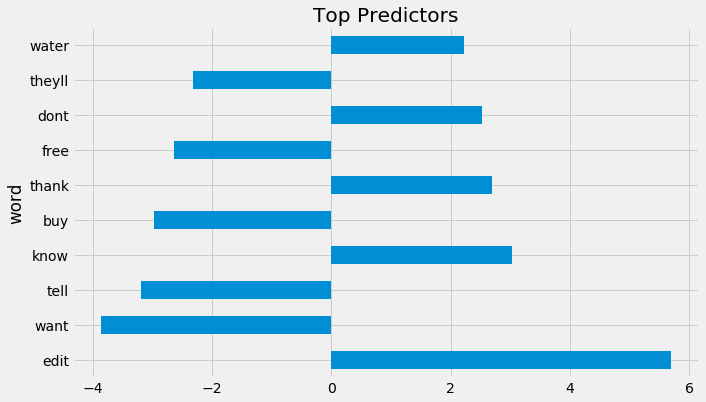

In [95]:
plt.style.use('fivethirtyeight')
coef_df_1.drop("abs_values", axis = 1).plot(kind = "barh", legend = None, figsize = (10,6), 
                                            title = "Top Predictors", fontsize = 14,
                                           )

| Model                           | Accuracy Score |
|---------------------------------|----------------|
| CV MultinomialNB                | 0.75           |
| TF-IDF MultinomialNB            | 0.76           |
| CV Logistic Regression          | 0.75           |
| TF-IDF Logistic Regression      | 0.77           |
| CV Random Forest Classifier     | 0.75           |
| TF-IDF Random Forest Classifier | 0.76           |
| CV Extra Trees Classifier       | 0.73           |
| TF-IDF Extra Trees Classifier   | 0.76           |
| CV AdaBoost Classifier          | 0.72           |
| TF-IDF AdaBoost Classifier      | 0.69           |
| Voting Classifier               | 0.77           |


| Model                           | Accuracy Score | Specificity Score |
|---------------------------------|----------------|-------------------|
| CV MultinomialNB                | 0.75           | 0.70              |
| TF-IDF MultinomialNB            | 0.76           | 0.71              |
| CV Logistic Regression          | 0.75           | 0.86              |
| TF-IDF Logistic Regression      | 0.77           | 0.80              |
| CV Random Forest Classifier     | 0.75           | 0.86              |
| TF-IDF Random Forest Classifier | 0.76           | 0.88              |
| CV Extra Trees Classifier       | 0.73           | 0.82              |
| TF-IDF Extra Trees Classifier   | 0.76           | 0.85              |
| CV AdaBoost Classifier          | 0.72           | 0.76              |
| TF-IDF AdaBoost Classifier      | 0.69           | 0.77              |
| Voting Classifier               | 0.77           | 0.88              |

In [96]:
print(gs_6.best_params_)

{'rf__max_depth': None, 'rf__n_estimators': 80, 'tvect__max_df': 0.7, 'tvect__ngram_range': (1, 1)}


In [97]:
rf_1 = RandomForestClassifier(n_estimators=80)
tfidf = TfidfVectorizer(max_df=0.7, ngram_range=(1,1), stop_words="english")

In [98]:
tvect_fi = tfidf.fit_transform(X_train)
tvect_fi_test = tfidf.transform(X_test)

In [99]:
rf_1.fit(tvect_fi, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
rf_1.score(tvect_fi_test, y_test)

0.7565055762081785

In [101]:
rf_1.feature_importances_

array([3.80468589e-05, 1.26513637e-06, 4.42910246e-07, ...,
       3.67127819e-05, 3.59414855e-05, 1.55631325e-04])

In [102]:
feature_importance = pd.DataFrame({'word': tfidf.get_feature_names(), 'feature_importances': rf_1.feature_importances_})

df_fi = feature_importance.sort_values("feature_importances", ascending = False).head(10)

In [103]:
df_fi

,word,feature_importances
2514,edit,0.025313
8408,want,0.014100
7645,tell,0.008538
2364,dont,0.008093
4285,know,0.007628
7691,thank,0.007246
3154,free,0.006145
8232,use,0.006061
1144,buy,0.005884
4222,just,0.005449


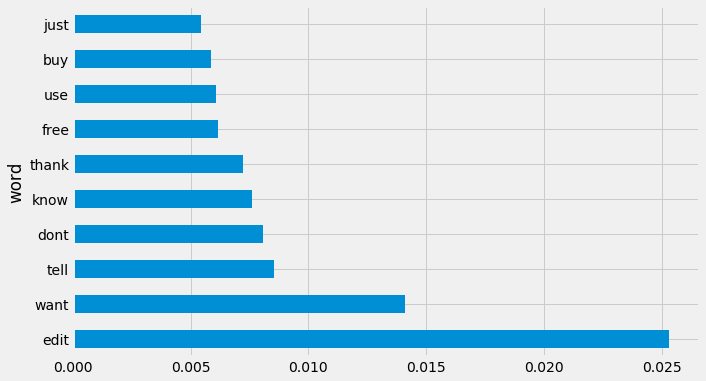

In [104]:
plt.style.use('fivethirtyeight')
df_fi.plot(kind="barh", x="word",legend=False, figsize=(10,6))
